# Forecating the Energy Consumption 

In [2]:
#importing the general packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Ignoring the warning
import warnings
warnings.filterwarnings('ignore')

In [6]:
from time import time
import math
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf

In [7]:
# Importing the scikit-learn packages
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error 

In [8]:
#Importing the Keras packages
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [29]:
#Reading the data 
df=pd.read_csv('household_power_consumption.txt', sep=';', header=0, low_memory=False, infer_datetime_format=True, 
               parse_dates={'datetime':[0,1]})

#  Data understanding

In [30]:
# Data visualize
df.head(5)

,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [31]:
# Data shape
df.shape

(2075259, 8)

In [32]:
# Looking at the null values
df.isnull().sum()

datetime                     0
Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
dtype: int64

In [33]:
# Looking the datatypes
df.dtypes

datetime                 datetime64[ns]
Global_active_power              object
Global_reactive_power            object
Voltage                          object
Global_intensity                 object
Sub_metering_1                   object
Sub_metering_2                   object
Sub_metering_3                  float64
dtype: object

In [34]:
# Handling data consistency issue
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce') 

In [35]:
#Create year, quarter, month and day features
df['year'] = df['datetime'].apply(lambda x: x.year)
df['quarter'] = df['datetime'].apply(lambda x: x.quarter)
df['month'] = df['datetime'].apply(lambda x: x.month)
df['day'] = df['datetime'].apply(lambda x: x.day)

In [36]:
# Create Weekday or weekend feature: Create weekday =“1” is weekend =“0” 
df=df.loc[:,['datetime','Global_active_power', 'year','quarter','month','day']]
df.sort_values('datetime', inplace=True, ascending=True)
df["weekday"]=df.apply(lambda row: row["datetime"].weekday(),axis=1)
df["weekday"] = (df["weekday"] < 5).astype(int)

In [39]:
# Dropping the null values and check the shape
df=df.dropna()


In [40]:
df.shape

(2049280, 7)

In [42]:
# Pring maximum and minimum date time
print('The time series starts from: ', df.datetime.min())
print('The time series ends on: ', df.datetime.max())

The time series starts from:  2006-12-16 17:24:00
The time series ends on:  2010-11-26 21:02:00


# Statistical testing of data for normality
Our null hypothesis H_o= the data is normal
- p <= 0.05: reject_H0, not normal.
- 
p > 0.05: fail to reject H0, normal.

In [43]:
#Calculating the statistic and p-value 
stat, p = stats.normaltest(df.Global_active_power)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')

Statistics=724881.795, p=0.000
Data does not look Gaussian (reject H0)


In [44]:
#Looking at the general statistics of Global_active_power
df.Global_active_power.describe()

count    2.049280e+06
mean     1.091615e+00
std      1.057294e+00
min      7.600000e-02
25%      3.080000e-01
50%      6.020000e-01
75%      1.528000e+00
max      1.112200e+01
Name: Global_active_power, dtype: float64

- Mean and median are not same so lets plot the dist plot for distribution of data

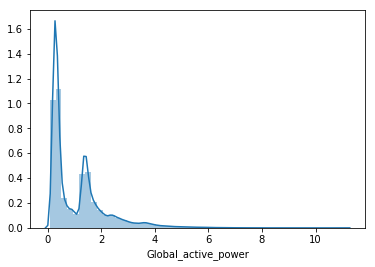

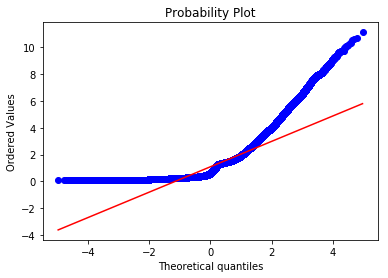

In [54]:
# data distribution by distplot & probability plot for normality test 
plt.figure()
sns.distplot(df.Global_active_power);
plt.figure()
stats.probplot(df['Global_active_power'], plot=plt);

- This data is bimodel and has heavy tail in right-> right skewed and Higher peak 

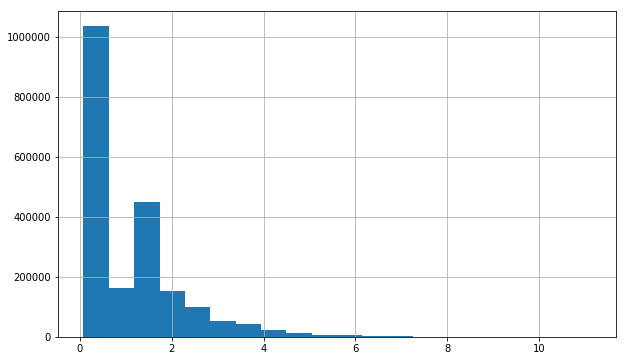

In [56]:
# Again plot the histogram
plt.figure(figsize=(10,6))
df['Global_active_power'].hist(bins=20)

In [46]:
# Let's look at the skewness of the data
print( 'Skewness of normal distribution: {}'.format(stats.skew(df.Global_active_power)))

Skewness of normal distribution: 1.7862320846320818


- skewness between (-0.5, 0.5) = symmetrical. 
- skewness is between (-1 , – 0.5) or between (0.5, 1)= moderately skewed. 
-  skewness < -1 or > 1, the data are highly skewed on left or right respectively. 

And our skewness is greater than 1 so our data is higly right skewed.

In [47]:
# Let's look at the curtosis
print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(df.Global_active_power)))

Kurtosis of normal distribution: 4.218671866132124


- Normal Distribution:: kurtosis of close to 0. 
- kurtosis is greater than zero, then distribution has heavier tails. 
- kurtosis is less than zero, then the distribution is light tails. 

And our Kurtosis is greater than zero means we have heavy tails.

# Data Visualizing

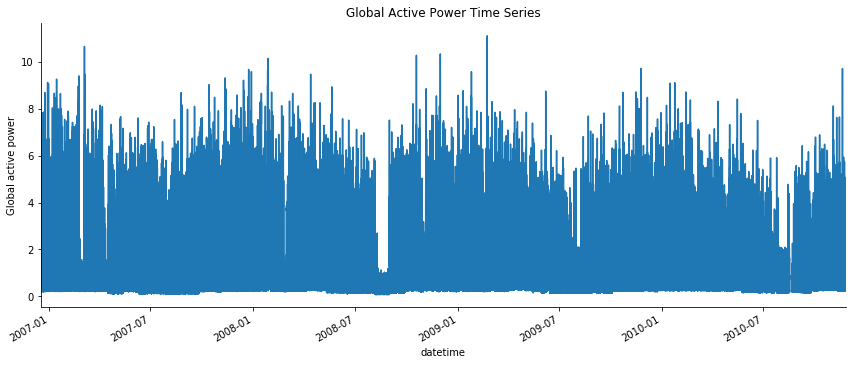

In [48]:
# Ploting the Global_active_power against the time
df1=df.loc[:,['datetime','Global_active_power']]
df1.set_index('datetime',inplace=True)
df1.plot(figsize=(12,5))
plt.ylabel('Global active power')
plt.legend().set_visible(False)
plt.tight_layout()
plt.title('Global Active Power Time Series')
sns.despine(top=True)
plt.show();

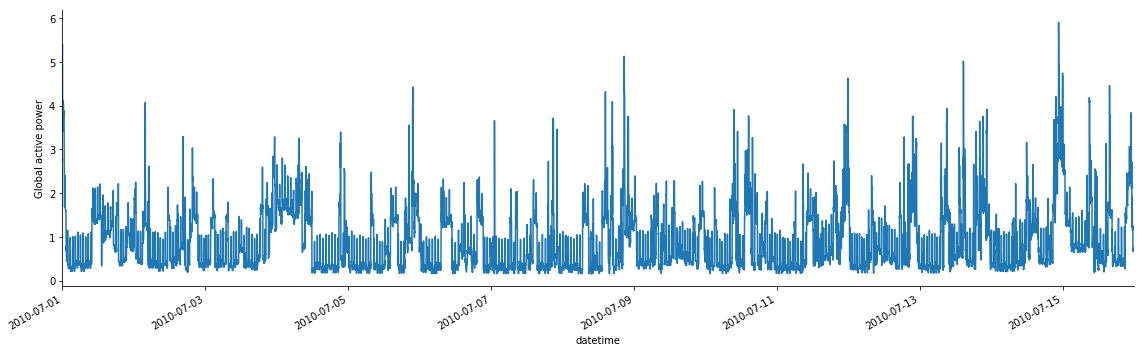

In [49]:
#power consumption for july 2010
df2=df1[(df1.index>='2010-07-01') & (df1.index<'2010-7-16')]
df2.plot(figsize=(16,5));
plt.ylabel('Global active power')
plt.legend().set_visible(False)
plt.tight_layout()
sns.despine(top=True)
plt.show();

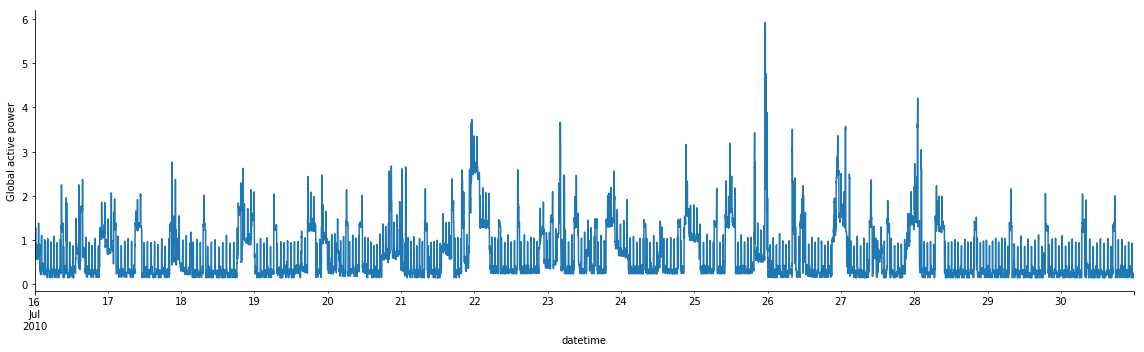

In [50]:
#power consumption for july 2010
df2=df1[(df1.index>='2010-07-16') & (df1.index<'2010-7-31')]
df2.plot(figsize=(16,5));
plt.ylabel('Global active power')
plt.legend().set_visible(False)
plt.tight_layout()
sns.despine(top=True)
plt.show();

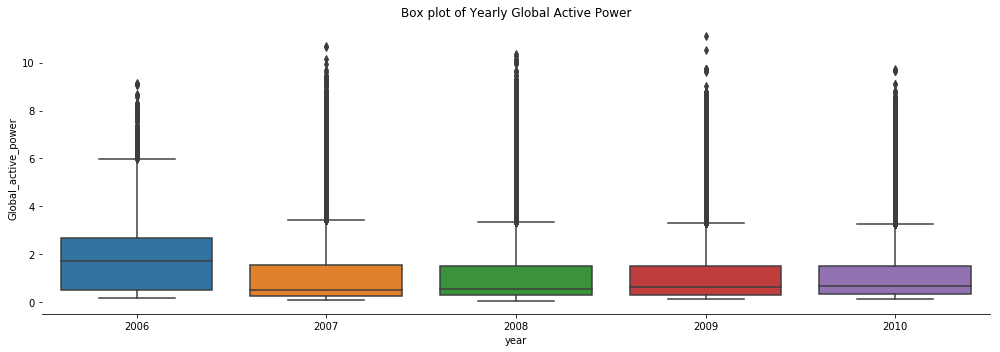

In [51]:
#Box plot for yearly consumption of global_power_consumption
plt.figure(figsize=(14,5))
sns.boxplot(x="year", y="Global_active_power", data=df)
plt.xlabel('year')
plt.title('Box plot of Yearly Global Active Power')
sns.despine(left=True)
plt.tight_layout() 

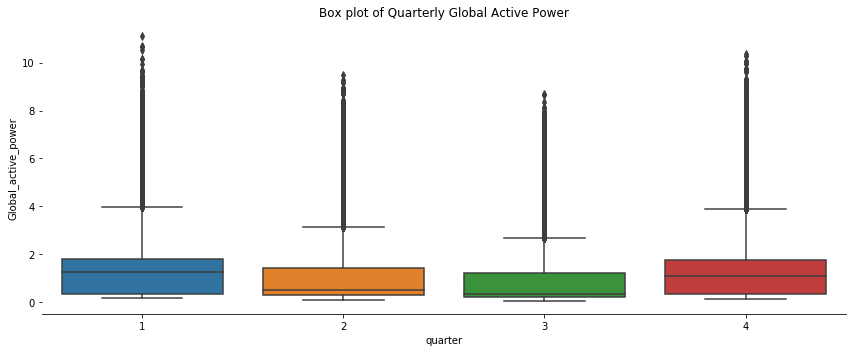

In [52]:
#Box plot for quarterly Global_active_power
plt.figure(figsize=(12,5))
sns.boxplot(x="quarter", y="Global_active_power", data=df)
plt.xlabel('quarter')
plt.title('Box plot of Quarterly Global Active Power')
sns.despine(left=True)
plt.tight_layout();

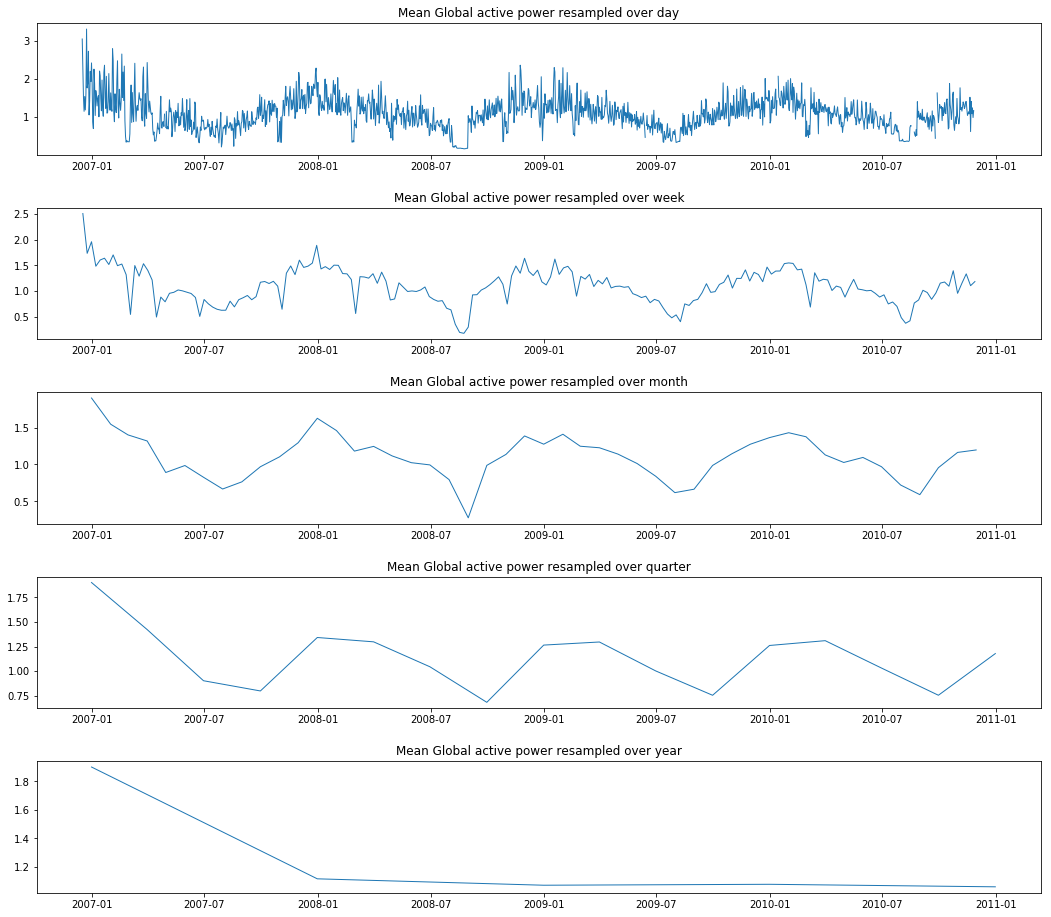

In [57]:
# comparing Global_active_power uses over day, week, month, quarter and year together
fig = plt.figure(figsize=(18,16))
fig.subplots_adjust(hspace=.4)
ax1 = fig.add_subplot(5,1,1)
ax1.plot(df1['Global_active_power'].resample('D').mean(),linewidth=1)
ax1.set_title('Mean Global active power resampled over day')
ax1.tick_params(axis='both', which='major')

ax2 = fig.add_subplot(5,1,2, sharex=ax1)
ax2.plot(df1['Global_active_power'].resample('W').mean(),linewidth=1)
ax2.set_title('Mean Global active power resampled over week')
ax2.tick_params(axis='both', which='major')

ax3 = fig.add_subplot(5,1,3, sharex=ax1)
ax3.plot(df1['Global_active_power'].resample('M').mean(),linewidth=1)
ax3.set_title('Mean Global active power resampled over month')
ax3.tick_params(axis='both', which='major')

ax4  = fig.add_subplot(5,1,4, sharex=ax1)
ax4.plot(df1['Global_active_power'].resample('Q').mean(),linewidth=1)
ax4.set_title('Mean Global active power resampled over quarter')
ax4.tick_params(axis='both', which='major')

ax5  = fig.add_subplot(5,1,5, sharex=ax1)
ax5.plot(df1['Global_active_power'].resample('A').mean(),linewidth=1)
ax5.set_title('Mean Global active power resampled over year')
ax5.tick_params(axis='both', which='major');

We can clearly see that before july 2007 the power uses was high and started to decline till jan 2018 and remain constant afer jan 2018. 


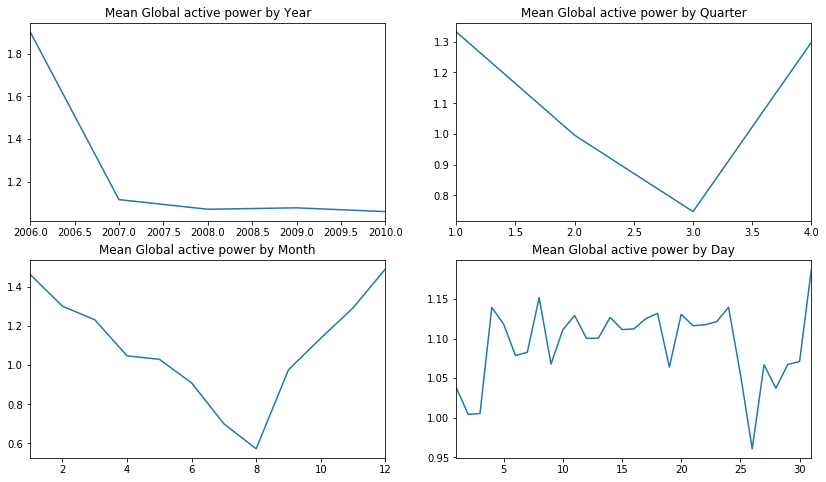

In [58]:
# Let's look at the Average consumption of Global power energy over different period 
plt.figure(figsize=(14,8))
plt.subplot(2,2,1)
df.groupby('year').Global_active_power.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Global active power by Year')

plt.subplot(2,2,2)
df.groupby('quarter').Global_active_power.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Global active power by Quarter')

plt.subplot(2,2,3)
df.groupby('month').Global_active_power.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Global active power by Month')

plt.subplot(2,2,4)
df.groupby('day').Global_active_power.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Global active power by Day');

- By quarter, the lowest average power consumption was in the 3rd quarter. 
- By month, the lowest average power consumption was in July and August.
- By day, the lowest average power consumption was around 27th of the month

<Figure size 432x288 with 0 Axes>

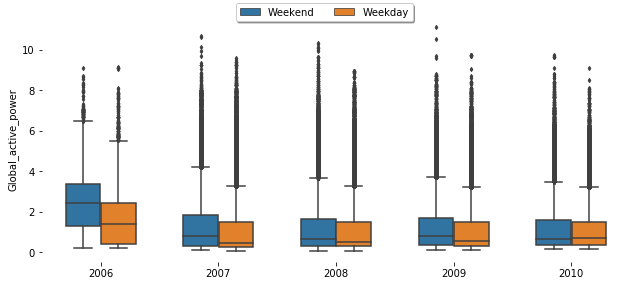

<Figure size 432x288 with 0 Axes>

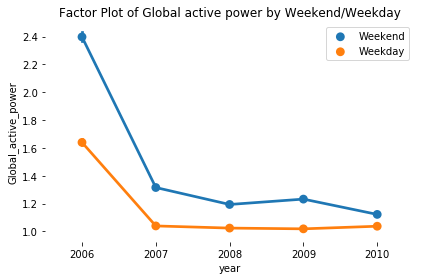

In [61]:
# Weekend and Weekday energy consumption
plt.figure()
dic={0:'Weekend',1:'Weekday'}
df['Day'] = df.weekday.map(dic)

a=plt.figure(figsize=(9,4)) 
plt1=sns.boxplot('year','Global_active_power',hue='Day',width=0.6,fliersize=3,
                    data=df)                                                                                                                                                                                                                                                                                                                                                 
a.legend(loc='upper center', bbox_to_anchor=(0.5, 1.00), shadow=True, ncol=2)
sns.despine(left=True, bottom=True) 
plt.xlabel('')
plt.tight_layout()                                                                                                                  
plt.legend().set_visible(False);

plt.figure()

plt1=sns.factorplot('year','Global_active_power',hue='Day',
                    data=df, size=4, aspect=1.5, legend=False)                                                                                                                                                                                                                                                                                                                                             
plt.title('Factor Plot of Global active power by Weekend/Weekday')                                                             
plt.tight_layout()                                                                                                                  
sns.despine(left=True, bottom=True) 
plt.legend(loc='upper right');

In [80]:
# histogram plot for each variable
plt.figure()
for i in range(len(df.columns)):
    plt.subplot(len(df.columns), 1, i+1)
    name = df.columns[i]
    df[name].hist(bins=100)
    plt.title(name, y=0)
plt.show()

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x0000016A743566A8> (for post_execute):


KeyboardInterrupt: 

In [ ]:
#Histogram for yearwise consumption
years = ['2007', '2008', '2009', '2010']
plt.figure()
for i in range(len(years)):
    # prepare subplot
    ax = plt.subplot(len(years), 1, i+1)
    # determine the year to plot
    year = years[i]
    # get all observations for the year
    result = df[str(year)]
    # plot the active power for the year
    result['Global_active_power'].hist(bins=100)
    # zoom in on the distribution
    ax.set_xlim(0, 5)
    # add a title to the subplot
    plt.title(str(year), y=0, loc='right')
plt.show()

In [ ]:
# Yearwise uses: removed 2006 because it has only december data
pd.pivot_table(df.loc[df['year'] != 2006], values = "Global_active_power", 
               columns = "year", index = "month").plot(subplots = True, figsize=(12, 12), layout=(3, 5), sharey=True);

In [ ]:
# Monthwise consumption for 2007
months = [x for x in range(1, 13)]
plt.figure()
for i in range(len(months)):
    # prepare subplot
    ax = plt.subplot(len(months), 1, i+1)
    # determine the month to plot
    month = '2007-' + str(months[i])
    # get all observations for the month
    result = df[month]
    # plot the active power for the month
    result['Global_active_power'].hist(bins=100)
    # zoom in on the distribution
    ax.set_xlim(0, 5)
    # add a title to the subplot
    plt.title(month, y=0, loc='right')
plt.show()

In [ ]:
# plot for first 15 days of 2009 January
# plot active power for each year
days = [x for x in range(1, 15)]
plt.figure()
for i in range(len(days)):
    # prepare subplot
    ax = plt.subplot(len(days), 1, i+1)
    # determine the day to plot
    day = '2009-01-' + str(days[i])
    # get all observations for the day
    result = df[day]
    # plot the active power for the day
    plt.plot(result['Global_active_power'])
    # add a title to the subplot
    plt.title(day, y=0, loc='left')
plt.show()

In [ ]:
# Checking for statinary
df2=df1.resample('D', how=np.mean)

def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=30).mean()
    rolstd = timeseries.rolling(window=30).std()
    
    plt.figure(figsize=(14,5))
    sns.despine(left=True)
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    plt.legend(loc='best'); plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    print ('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [ ]:
test_stationarity(df2.Global_active_power.dropna())

# Model Fitting 
- multi-layered LSTM RNN to predict the last value of a sequence of values
- here we predict values for a timeseries given the history of 2 million minutes of a household's power consumption

In [62]:
# create the dataset for the global power consumption
data1 = df.Global_active_power.values 
data1 = data1.astype('float32')

Normalize the features

In [63]:
# data scaling or transformation: MinMax scaling
data1 = np.reshape(data1, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
data1 = scaler.fit_transform(data1)

In [65]:
# Train Test split of data: 80-20 ratio
train_size = int(len(data1) * 0.80)
test_size = len(data1) - train_size
train, test = data1[0:train_size,:], data1[train_size:len(data1),:]

In [66]:
# pring train test size
train.shape, test.shape

((1639424, 1), (409856, 1))

In [67]:
#Convert an array of values into a dataset matrix
def Matrix_convertion(data1, look_back=1):
    X, Y = [], []
    for i in range(len(data1)-look_back-1):
        a = data1[i:(i+look_back), 0]
        X.append(a)
        Y.append(data1[i + look_back, 0])
    return np.array(X), np.array(Y)

In [68]:
# reshape into X=t and Y=t+1
look_back = 30
X_train, Y_train = Matrix_convertion(train, look_back)
X_test, Y_test = Matrix_convertion(test, look_back)

In [69]:
X_train.shape, Y_train.shape

((1639393, 30), (1639393,))

In [70]:
X_test.shape, Y_test.shape

((409825, 30), (409825,))

Reshape input to be 3D (num_samples, num_timesteps, num_features

In [73]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [74]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=20, batch_size=70, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)
# Training Phase
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 1639393 samples, validate on 409825 samples
Epoch 1/20
1639393/1639393 [==============================] - 137s 84us/step - loss: 7.5666e-04 - val_loss: 4.2293e-04
Epoch 2/20
1639393/1639393 [==============================] - 134s 82us/step - loss: 6.6126e-04 - val_loss: 4.0721e-04
Epoch 3/20
1639393/1639393 [==============================] - 128s 78us/step - loss: 6.5085e-04 - val_loss: 4.0486e-04
Epoch 4/20
1639393/1639393 [==============================] - 134s 82us/step - loss: 6.4709e-04 - val_loss: 3.9582e-04
Epoch 5/20
1639393/1639393 [==============================] - 135s 83us/step - loss: 6.3924e-04 - val_loss: 4.0613e-04
Epoch 6/20
1639393/1639393 [==============================] - 132s 80us/step - loss: 6.3602e-04 - val_loss: 3.9704e-0

In [75]:
# predicting for train and test set
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

Since we transformed the data into min-max transformation so we need to invert back the original value for this we need to invert transform the value


In [76]:
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

In [77]:
# printing the RMSE (root mean square error) and MAE(mean absolute error)
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Train Mean Absolute Error: 0.09342394376676706
Train Root Mean Squared Error: 0.26512803867231327
Test Mean Absolute Error: 0.07751290461312202
Test Root Mean Squared Error: 0.21638828427610035


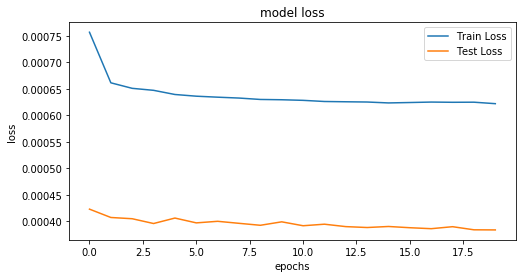

In [78]:
# plotting the loss for training data and test data
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

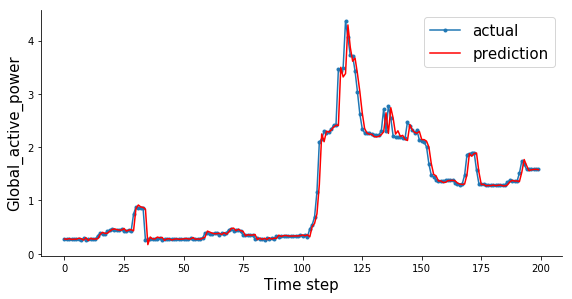

In [79]:
# Plotting the actual vs predicted data
aa=[x for x in range(200)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:200], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:200], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

***The End***